In [1]:
import numpy as np
import os
import time
import random
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn.init as init
from tqdm import tqdm
from torchsummary import summary
from torchmetrics.classification import MulticlassF1Score
from utils.load_data import ECGDataset, ECGCollate, SmartBatchSampler, load_dataset, load_ecg
from resnet1d import ResNet1D
from utils.plot_utils import plot_lth_progress, plot_layerwise_remaining_params
from utils.save_utils import save_checkpoint, load_checkpoint
from utils.train_utils import train_model, create_tqdm_bar, calculate_priors, weights_init_kaiming
from utils.pruning_utils import Mask, prune, PrunedModel

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.


In [6]:
def iterative_pruning(pruning_params, network, train_loader, val_loader, loss_func, device, resume=False) : 
    """
    Perform iterative magnitude pruning with optional weight rewinding.

    At each step, the model is trained, pruned globally by magnitude, optionally
    rewound to its initial weights, and evaluated on a validation set.
    Supports checkpointing and resuming.

    Args:
        pruning_params (dict): Pruning configuration (percentage, number of steps,
            weight rewinding flag, layers to ignore, etc.).
        network (nn.Module): Initial neural network to prune.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        loss_func (nn.Module): Loss function used for training.
        device (torch.device): Device used for training and evaluation.
        resume (bool, optional): Resume from checkpoint if available.

    Returns:
        current_mask (Mask): Final pruning mask.
        history_theta (list[float]): Reduction factor after each pruning step.
        history_f1 (list[float]): Validation F1 score history.
    """
    # Initialization
    checkpoint_file = f"checkpoints/iterative_pruning_weight_rewinding_{str(pruning_params['weight_rewinding'])}_checkpoint.pth"
    
    pruning_percentage = pruning_params["pruning_percentage"]
    n = pruning_params['nb_of_steps']
    
    current_mask = Mask.ones_like(network) # mask init
    current_mask_np = current_mask.numpy()
    initial_weights_number = np.sum([np.sum(v) for v in current_mask_np.values()]) # eta in Sahu et al. (2022)
    remaining_weights_number = initial_weights_number
    
    initial_untrained_model = copy.deepcopy(network)
    prior = calculate_priors(train_loader,device,4,500).to(device)
    f1_metric = MulticlassF1Score(num_classes=4, average=None).to(device)

    # Lists for backup 
    history_theta = []
    history_f1 = []
    history_sparsity = []
    
    step = 0

    # In case we interrupted the experience and we want to resume it at the step it stopped
    if resume and os.path.exists(checkpoint_file):
        
        checkpoint = load_checkpoint(checkpoint_file)
        
        step = checkpoint['step']
        pruning_percentage = checkpoint['pruning_percentage']
        current_mask = checkpoint['current_mask']
        history_theta = checkpoint['history_theta']
        history_f1 = checkpoint['history_f1']
        history_sparsity = checkpoint['history_sparsity']
        remaining_weights_number = sum(v.sum().item() for v in current_mask.values())
        
        # Set the initial weights (before any training)
        initial_untrained_model.load_state_dict(checkpoint['initial_weights'])
        
        # Create the current pruned model
        D = PrunedModel(model=copy.deepcopy(initial_untrained_model), mask=current_mask).to(device)
        
        print(f"Resume at step {step}")    

    else:
        D = copy.deepcopy(network)
    
    pruning_fraction = pruning_percentage/100

    for i in range(step,n+1) : 
        
        print(f"\n{'='*30} STEP {step} {'='*30}")
        print(f"Remaining_weights_number = {remaining_weights_number:.2e}")
        print("Current reduction factor (theta) = ", np.round(initial_weights_number/remaining_weights_number, 2))
        print("Pruning fraction = ", np.round(pruning_fraction,2))
        print("Model sparcity (percentage of weight that has been pruned): ", current_mask.sparsity )  
        
        # Train the DL network with the given data
        D,final_f1, f1_through_training = train_model(D, train_loader, val_loader, loss_func, device, prior = prior, epochs=20)

        # Backup
        # history_theta.append(initial_weights_number/remaining_weights_number)
        # history_sparsity.append(current_mask.sparsity)
        
        # Avoid nested PrunedModel    
        if isinstance(D, PrunedModel):
            model_to_prune = D.model
        else:
            model_to_prune = D

        # Prune p_init% of weights which are of least magnitude (Global Pruning)
        new_mask = prune(pruning_fraction, pruning_params["pruning_layers_to_ignore"], model_to_prune, current_mask)
        
        # New sparse model with trained weights 
        D_sparse = PrunedModel(model=model_to_prune,mask = new_mask).to(device)

        # Validation
        D_sparse.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Sparse Model [step : {step}]')
        f1_metric.reset()  # Reset pour calculer uniquement la val
        
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                ecgs, labels = batch
                ecgs, labels = ecgs.to(device), labels.to(device)

                pred = D_sparse(ecgs) 
                
                # Compute mean f1 score
                probs = F.softmax(pred, dim=1).transpose(1, 2)
                adjusted_probs = probs / prior
                indices = torch.argmax(adjusted_probs, dim=2)
                final_preds, _ = torch.mode(indices, dim=1)
                final_labels = labels[:, 0] if labels.dim() > 1 else labels
                f1_metric.update(final_preds, final_labels)

                current_val_f1s = f1_metric.compute()
                current_val_cinc = torch.mean(current_val_f1s[:3]).item() # Moyenne A, N, O
                
                # Update the progress bar.
                val_loop.set_postfix(f1_val=f"{current_val_cinc:.4f}")

       

        # Reset unpruned weights to their initial random values and D = D_sparse
        if pruning_params['weight_rewinding'] == True: 
            D = PrunedModel(model=copy.deepcopy(initial_untrained_model), mask=new_mask).to(device)
        else : 
            # Keep the trained weights no reseting to initial values
            D = PrunedModel(model=copy.deepcopy(D_sparse.model), mask=new_mask).to(device)

        remaining_weights_number = sum(v.sum().item() for v in new_mask.values())
       
        current_mask = new_mask
       
        step+=1
        
        history_theta.append(initial_weights_number/remaining_weights_number)
        history_sparsity.append(current_mask.sparsity)
        history_f1.append(current_val_cinc)

        # Backup the experience from current step in a checkpoint file
        checkpoint_state = {
            'step': step,
            'pruning_percentage': pruning_percentage,
            'current_mask': current_mask,
            'initial_weights': initial_untrained_model.state_dict(),
            'reduction_factor': initial_weights_number / remaining_weights_number,
            'history_theta': history_theta,
            'history_f1': history_f1,
            'history_sparsity': history_sparsity,
            'layerwise_sparcity': current_mask.layerwise_sparsity(),
            'layerwise_remaining_params': current_mask.layerwise_remaining_params()
        }
        save_checkpoint(checkpoint_state, filename=checkpoint_file)

         # Plot figures and save them every 5 steps 
        if step % 5 == 0:
            path = f'plots/iterative_pruning_weight_rewinding_{str(pruning_params['weight_rewinding'])}/'
            plot_lth_progress(history_theta, history_f1, path)
            plot_layerwise_remaining_params(D_sparse, current_mask, path)

        print("="*60, "\n")
    
    # Final plot
    plot_lth_progress(history_theta, history_f1, path)

    return current_mask, history_theta, history_f1




In [3]:
print("Loading training set...")
train = load_dataset("train.json",256) # 256 like in Hannun et al. 
train_ecgs, train_labels = train

print("Loading dev set...")
val_ecgs,val_labels = load_dataset("dev.json",256)


train_dataset = ECGDataset(train_ecgs, train_labels)
val_dataset = ECGDataset(val_ecgs, val_labels)

# Instanciation du Sampler intelligent
train_batch_sampler = SmartBatchSampler(train_dataset, 32)
val_batch_sampler = SmartBatchSampler(val_dataset, 32)

train_collate_fn = ECGCollate(
    pad_val_x=train_dataset.pad_value_x_normalized,
    num_classes=train_dataset.num_classes
    )

val_collate_fn = ECGCollate(
    pad_val_x=val_dataset.pad_value_x_normalized,
    num_classes=val_dataset.num_classes
    )

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_batch_sampler, 
    collate_fn=train_collate_fn,
    num_workers=4
    )

val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_batch_sampler, 
    collate_fn=val_collate_fn,
    num_workers=4
    )


Loading training set...


100%|██████████| 7676/7676 [00:01<00:00, 4256.54it/s]


Loading dev set...


100%|██████████| 852/852 [00:00<00:00, 5701.85it/s]


MEAN :  7.4661856  STD :  236.10312
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}
MEAN :  8.029898  STD :  242.35907
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}
Sorting dataset by length to minimize padding...
Sorting dataset by length to minimize padding...


In [9]:
# Hyperparameters setting :
hparams = {
    "in_channels" : 1,  # Single lead ECG signals 
    "base_filters" : 32,  # 2 in Hannun et al.
    "kernel_size" : 16, 
    "stride" : 2, 
    "groups" : 1,  # to make a classic ResNet architecture
    "n_block" : 16,  # 16 in Hannun et al.
    "n_classes" : 4,  # Imposed by the Physionet 2017 dataset
    "downsample_gap" : 2, # every 2 block like in Hannun et al. 
    "increasefilter_gap" : 4,  # kernel_size doubles every 4 blocks
    "use_bn" : True,  # Use Batch Normalization layers
    "use_do" : True  # Use Dropout layers 
    } 

# Get GPU if available 
device_str = "cuda"
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Instantiate SOTA model for ECG Classification
model = ResNet1D(**hparams).to(device)

# Ensure to get the same initial weigths as in the other experience
checkpoint = load_checkpoint("checkpoints/lth_ecg_checkpoint.pth")
model.load_state_dict(checkpoint['initial_weights'])


Running on cuda
--> Checkpoint loading : checkpoints/lth_ecg_checkpoint.pth


<All keys matched successfully>

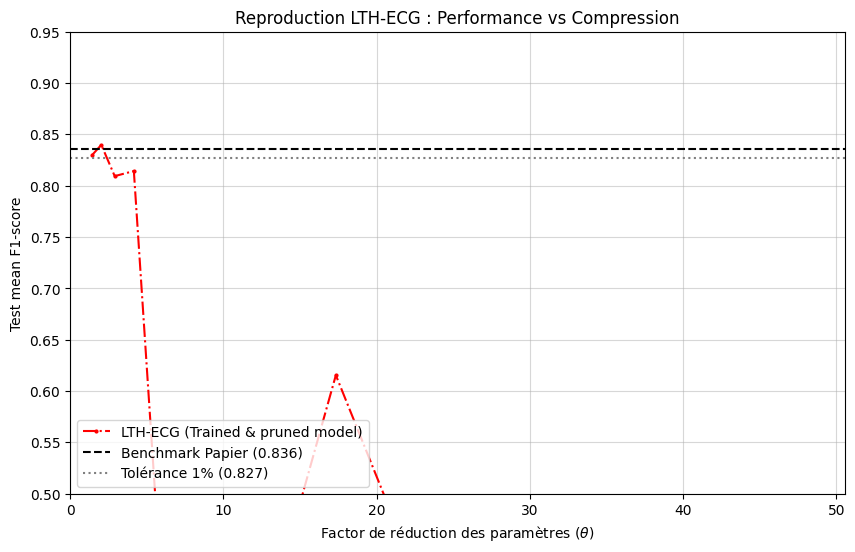

Graphique mis à jour et sauvegardé dans : plots/iterative_pruning_weight_rewinding_True/lth_performance_plot.png


In [10]:
# The loss function we use for classification.
loss_func = nn.CrossEntropyLoss() 


pruning_params = {
                  "pruning_percentage" : 30, # denoted as p in Frankle & Carbin
                  "nb_of_steps" : 10, # denoted as n in Frankle & Carbin
                  "pruning_layers_to_ignore" : None,
                  "weight_rewinding": True
                  }

# Run Iterative pruning experience as described in Frankle and Carbin (2019)
final_mask, history_theta, history_f1 = iterative_pruning(pruning_params, model, train_loader, val_loader, loss_func, device) 